# Packages

In [1]:
import pandas as pd  # For data manipulation and analysis
import random  # For generating random numbers
import itertools  # For efficient looping
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import scipy.stats as stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from scipy.stats import ttest_ind, norm  # For conducting t-tests and working with normal distributions
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest regression models
from sklearn.linear_model import Lasso  # For using Lasso regression models
from sklearn.preprocessing import StandardScaler  # For feature scaling

import statsmodels.api as sm  # For statistical models and tests
import statsmodels.formula.api as smf  # For statistical models with formula interface
from linearmodels.panel import PanelOLS  # For panel data models
from tqdm import tqdm  # For adding progress bars to loops
import glob as glob

# Set the random seed for reproducibility
random.seed(123)

# Initialize the scaler
scaler = StandardScaler()

def formula_add(data):
    text = ""
    for i in data:
        text = f"{text} + {i}"
    
    return text


## Organización de la base

In [2]:
inf = pd.read_excel("INPUT/weo_Apr2023.xlsx")

In [35]:
info = inf[["country", "WEO_CODE", "year", "PCPI", "GGXWDG", "NGDP"]]
info["PI"] = info.groupby(["WEO_CODE"])["PCPI"].pct_change()*100
info["DEBT_GDP"] = info["GGXWDG"]/info["NGDP"]
inf10 = info[info.year==2020][["WEO_CODE", "PCPI"]]; inf10.columns = ["WEO_CODE", "PCPI_10"]
info = info.merge(inf10, "left", "WEO_CODE")
info["PCPI_B10"] = (info["PCPI"]/info["PCPI_10"])*100
info["ACTUAL_PIB10"] = info.groupby(["WEO_CODE"])["PCPI_B10"].pct_change()
info = info[['country', 'WEO_CODE', 'year', 'PI','DEBT_GDP', 'PCPI_B10']]
info.columns = ["COUNTRY_NAME", "WEO_CODE", "DATE", "PI", "DEBT_GDP", "PI_I"]
info = info[info.DATE<=2022]

inff = pd.read_excel("INPUT/WEOhistorical.xlsx", sheet_name="pcpi_pch_arranged")
inff = inff[['WEO_CODE', 'DATE', 'PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']]
infr = info.merge(inff, "left", ["WEO_CODE", "DATE"]).dropna()

qsi = infr.PI.quantile(0.95)
qii = infr.PI.quantile(0.05)

# qsd = infr.DEBT_GDP.quantile(0.95)
# qid = infr.DEBT_GDP.quantile(0.05)

infr = infr[(infr.PI<qsi) & (infr.PI>qii)]
# infr = infr[(infr.DEBT_GDP<qsd) & (infr.DEBT_GDP>qid)]

for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
    infr[i] = np.log(0.00000000001+np.abs(infr["PI"]-infr[i]))
    # infr[i] = np.log(1+np.abs(infr["PI"]-infr[i]))
    # infr[i] = np.exp(infr["PI"]-infr[i])

<ipython-input-35-84090ca08416>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info["PI"] = info.groupby(["WEO_CODE"])["PCPI"].pct_change()*100
<ipython-input-35-84090ca08416>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info["DEBT_GDP"] = info["GGXWDG"]/info["NGDP"]


In [36]:
# def calculate_forecast_index(row, forecast_col):
#     previous_year_index = infr[(infr['WEO_CODE'] == row['WEO_CODE']) & (infr['DATE'] == row['DATE'] - 1)]['PI_I']
#     if not previous_year_index.empty:
#         return previous_year_index.values[0] * (1 + row[forecast_col] / 100)
#     else:
#         return np.nan

# for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
#     infr[i] = infr.apply(lambda row: calculate_forecast_index(row, i), axis=1)

# for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
#     infr[i] = (infr[i]-infr["PI_I"])/infr["PI_I"]


    # K = 1
    # K = np.log(1+np.abs(infr["PI"]-infr[i])).mean()
    # print(K)
    # infr[i] = np.log(1+np.abs(infr["PI"]-infr[i]))
    # infr[i]

In [37]:
# infr[infr['PI_ST5'].isna()]
# infr[infr['PI_ST5']==0]
# infr = infr.dropna()

# XY = infr.set_index(["WEO_CODE", "DATE"]).dropna()

# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2']
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3']
# XINF = ['PI_ST5', 'PI_ST4'] #CON ESTA ES
# XINF = ['PI_ST5']

# formula = f"PI ~  {formula_add(XINF)} + EntityEffects + TimeEffects"
# formula = f"PI ~  {formula_add(XINF)}"
# formula = f"PI ~  PI_ST4 "
# modelols = PanelOLS.from_formula(formula, data=XY)
# modelols = modelols.fit()
# modelols.summary

# XY["A"] = modelols.predict()
# XY["PI"].plot(kind = "hist")
# XY["A"].plot(kind = "hist")

### Fislac y Totaldataset

In [38]:
dfislac = pd.read_excel("INPUT/FISLAC_update.xlsx")
# totaldfr = pd.read_csv("INPUT/total_dataset_20230911.csv")

In [76]:
# D       = ["DEBT_GDP"] #DEUDA
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL", "GDP_R_GR", "DOM_DEBT"] #CONTROLES DE LA DEUDA
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] #OTROS CONTROLES: INSTITUCIONALES + APERTURA
IDS     = ["COUNTRY_NAME", "WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"]

dfislac2 = dfislac[IDS+C_DEUDA+C_INS]

### Profundidad financiera
deepf = pd.read_excel("INPUT/Data_profundidad_financiera.xlsx")
deepf = deepf[["WEO_CODE", "DATE", "ka_open", "pnfs_nfs", "dom_debt_sh"]]
deepf["pnfs_nfs"] = deepf["pnfs_nfs"]/100
deepf.columns = [i.upper() for i in deepf.columns]

## restricción financiera
bank = pd.read_excel("INPUT/BANK_OWNERSHIP.xlsx")
bank = bank[["ISO", "year", "FOR1_DB"]]
bank = bank.rename(columns = {"ISO":"ISO3", "year": "DATE"})

dff = infr.merge(dfislac2, "left", ["WEO_CODE", "DATE"])

### Creación de covariables
D = ["DEBT_GDP"]
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"] 
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] 

C_DEUDA_L = [f"{i}_l1" for i in C_DEUDA]

for i,e in zip(C_DEUDA, C_DEUDA_L):
    dff[e] = dff.groupby("WEO_CODE")[i].shift(1)


XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1'] #128.
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2'] #139.44
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3'] #145
# XINF = ['PI_ST5', 'PI_ST4'] #CON ESTA ES, 146
# XINF = ['PI_ST5'] #144

dff = dff[["WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + C_DEUDA + C_INS + XINF + C_DEUDA_L ].dropna()

In [77]:
XY = dff.set_index(["WEO_CODE", "DATE"]).dropna()

formula = f"PI ~  {formula_add(XINF)} + {formula_add(C_DEUDA_L)} +  {formula_add(C_INS)} + EntityEffects + TimeEffects"
# formula = f"PI ~  {formula_add(XINF)}"
# formula = f"PI ~  PI_ST4 "
modelols = PanelOLS.from_formula(formula, data=XY)
modelols = modelols.fit()
modelols.summary

Dep. Variable:,PI,R-squared:,0.1741
Estimator:,PanelOLS,R-squared (Between):,0.4362
No. Observations:,3916,R-squared (Within):,0.1931
Date:,"Sat, May 11 2024",R-squared (Overall):,0.3749
Time:,10:06:40,Log-likelihood,-8846.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,64.966
Entities:,180,P-value,0.0000
Avg Obs:,21.756,Distribution:,"F(12,3698)"
Min Obs:,1.0000,,
Max Obs:,27.000,F-statistic (robust):,64.966


In [41]:
dff = dff.merge(deepf, "left", ["WEO_CODE", "DATE"])
dff = dff.merge(bank, "left", ["ISO3", "DATE"])

<Axes: ylabel='Frequency'>

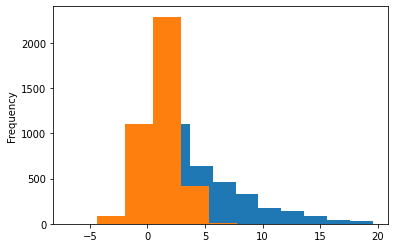

In [42]:
dff["PI_IV"] = modelols.predict().values
XY["A"] = modelols.predict()
XY["PI"].plot(kind = "hist")
XY["A"].plot(kind = "hist")

In [43]:
dff = dff.rename(columns = {"PI": "PIA"})

## Segundo nivel: Principal

### Paramétros

In [44]:
import os
results = "RESULTS"
os.makedirs(results, exist_ok=True)

In [58]:
# INF = 'CPI_PORCENTAJE' #SIN INSTRUMENTAR
# INF = 'PI_OLS' #INSTRUMENTADA
# INF = 'DESV_CPI_1990_A_F3'
# INF = 'INFLATION'
# INF = "PIA"
INF = "PI_IV"

os.makedirs(f'{results}/{INF}', exist_ok=True)

dff["PI"] = dff[INF].copy()

In [59]:
dff[["PIA", "PI_IV", "PI"]]

,PIA,PI_IV,PI
0,0.039381,1.778261,1.778261
1,3.120124,0.695303,0.695303
2,5.201573,1.049873,1.049873
3,2.362931,0.363573,0.363573
4,2.866863,-0.763529,-0.763529
...,...,...,...
3911,3.720451,5.614945,5.614945
3912,1.631622,2.704390,2.704390
3913,-0.212940,2.826511,2.826511
3914,0.907206,2.459875,2.459875


In [60]:
# dff.DEBT_GDP = dff.DEBT_GDP/100

In [61]:
# dff["PI"] = dff["PI"]*100

<Axes: ylabel='Frequency'>

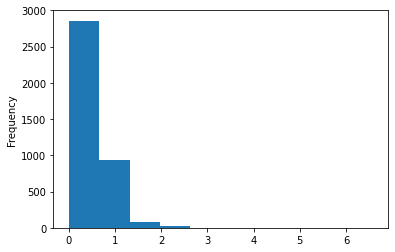

In [62]:
dff.DEBT_GDP.plot(kind = "hist")

In [63]:
dff.DEBT_GDP.quantile(0.95)

1.1482257245357301

In [64]:
dff.PI.quantile(0.95)

3.4952788081673525

In [65]:
D = ["DEBT_GDP"]

In [66]:
dfix = dff.copy()[["WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + C_DEUDA + C_INS + C_DEUDA_L ].dropna()
# dfix = dfix[dfix.DEBT_GDP>0]
dfix = dfix[dfix.DEBT_GDP<=2]
# dfix = dfix[dfix.PI<=0.2]
dfix = dfix[["WEO_CODE", "DATE"]]
dfr = dfix.merge(dff, "left", ["WEO_CODE", "DATE"])

In [67]:
dfr["DH"] = dfr["DEBT_GDP"].apply(lambda x: 1 if x>=0.487 else 0)
dfr["DH_PI"] = dfr["DH"]*dfr["PI"]
# dfr["PNFS_NFS"] = dfr["PNFS_NFS"]/100
# dfr["DTC" ] = dfr["DTC" ]*100

In [68]:
# dfr["DEBT_GDP"]= np.log(1+dfr["DEBT_GDP"])

In [69]:
# dfr["PI"] = np.log(1+dfr["PI"])

In [70]:
# dfr.to_excel("finaldb.xlsx", index = False)

### Estimación (tablas)

In [71]:
# dfr["DEBT_GDP"]

In [72]:
# dfr["PI"]

In [73]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
CONTROLES = ["2_ALLCONTROL"]

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  "PI"

for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dfr[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'

        # dfr["DEBT_GDP"] = np.log(1+dfr["DEBT_GDP"])
        # dfr["PI"] = dfr["PI"]*100
            
        model = smf.quantreg(formula, dfr)
        result = model.fit(q=qs)

        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]


        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [slope],
            'Lower': [lower],
            'Upper': [upper],
            "p-value": [pvalue],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    # result_df.to_excel(f'{results}/{INF}/{CONTROL}.xlsx', index = False)
    result_df.to_excel(f'{results}/{INF}/{CONTROL}_D.xlsx', index = False)


  7%|▋         | 7/99 [00:01<00:18,  5.05it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 38%|███▊      | 38/99 [00:07<00:10,  5.93it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 77%|███████▋  | 76/99 [00:15<00:04,  4.77it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 92%|█████████▏| 91/99 [00:19<00:01,  5.09it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of

### Gráficas

In [74]:
modelos = glob.glob(f'{results}/{INF}/*.xlsx')
# model = 

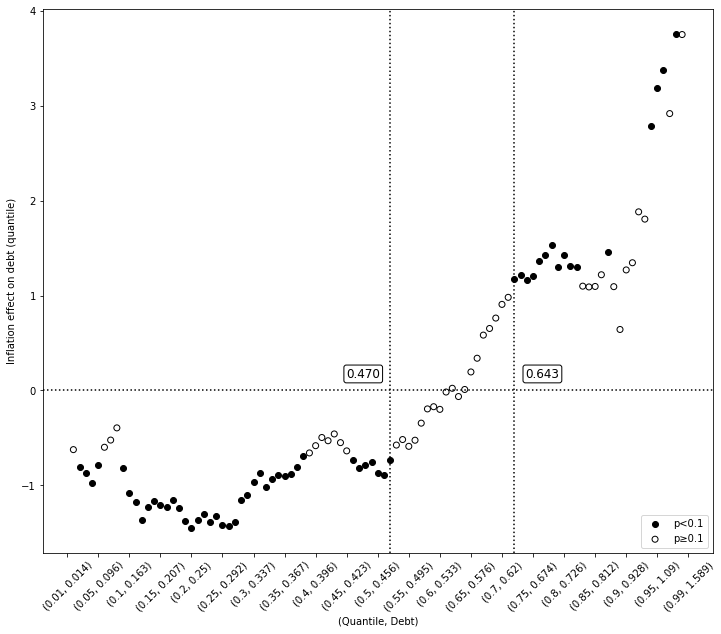

In [75]:
for i in modelos:

    try:
        result_df = pd.read_excel(i)
        ###################################################################################################################################################################
        plt.figure(figsize=(12, 10))
        ############################################################################################
        #SCATTER PLOT
        bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
        labels = [90, 70, 60, 40, 30, 20]
        result_df['Slope'] = result_df['Slope']*100
        result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

        result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
        significant = result_df[result_df['significative'] == 1]
        not_significant = result_df[result_df['significative'] == 0]
        # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
        # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1', s=not_significant["pc"])
        plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1')
        plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1')

        ############################################################################################
        # LINEAS DE THRESHOLD
        # Add a vertical line at x = threshold.Quantile with a label
        plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

        threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
        threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
        plt.axvline(x=threshold['Quantile'], color='black', linestyle='dotted')


        threshold_v2 = result_df[(result_df["significative"]==1) & (result_df["Slope"]>0)].iloc[0]
        threshold2 = {'Quantile': threshold_v2.Quantile, 'Quantile_value': threshold_v2.Quantile_value}
        plt.axvline(x=threshold2['Quantile'], color='black', linestyle='dotted')


        ############################################################################################
        #LABELS/LEYENDAS
        plt.xlabel(f'(Quantile, Debt)')
        plt.ylabel(f'Inflation effect on debt (quantile)')


        plt.annotate(
            f"{threshold['Quantile_value']:.3f}",
            # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
            xy=(threshold['Quantile'], 0),  # Position of the label
            xytext=(-10, 10),  # Offset for label placement (adjust as needed)
            textcoords='offset points',
            ha='right',  # Horizontal alignment of the label
            va='bottom',  # Vertical alignment of the label
            color='black',  # Text color
            fontsize=12,  # Text font size
            bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
            )

        plt.annotate(
            f"{threshold2['Quantile_value']:.3f}",
            # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
            xy=(threshold2['Quantile'], 0),  # Position of the label
            xytext=(45, 10),  # Offset for label placement (adjust as needed)
            textcoords='offset points',
            ha='right',  # Horizontal alignment of the label
            va='bottom',  # Vertical alignment of the label
            color='black',  # Text color
            fontsize=12,  # Text font size
            bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
            )


        plt.legend(scatterpoints=1, loc='lower right')

        ############################################################################################
        ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
        ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

        # ymax, ymin = 1.5, -0.6
        # ymax, ymin = 0.7, -0.2
        # plt.ylim(ymin, ymax)
        # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

        qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
        df_tick = result_df[result_df["Quantile"].isin(qsticks)]
        custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
        plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


        # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

        # plt.legend()
        # plt.grid(True)
        plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
        plt.grid(False)
        plt.show()
    
    except:
        None

## Chanel: depreciación

### Paramétros

In [215]:
DEPENDIENTE   =  "ER_DEP" 
INDEPENDIENTE =  "DH_PI"

os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [216]:
dftc = dfr[dfr.ER_DEP!=0]
# dftc = dfr.copy()

### Estimación (tablas)

In [217]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + WGI_GOV_IND + DEMOCRACY'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params["PI"]+result.params[INDEPENDIENTE]],
            # 'Slope': [result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


 19%|█▉        | 19/99 [00:02<00:09,  8.03it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 23%|██▎       | 23/99 [00:03<00:12,  5.86it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:10<00:00,  9.63it/s]
<ipython-input-217-afe2120981da>:46: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


### Gráficas

In [218]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

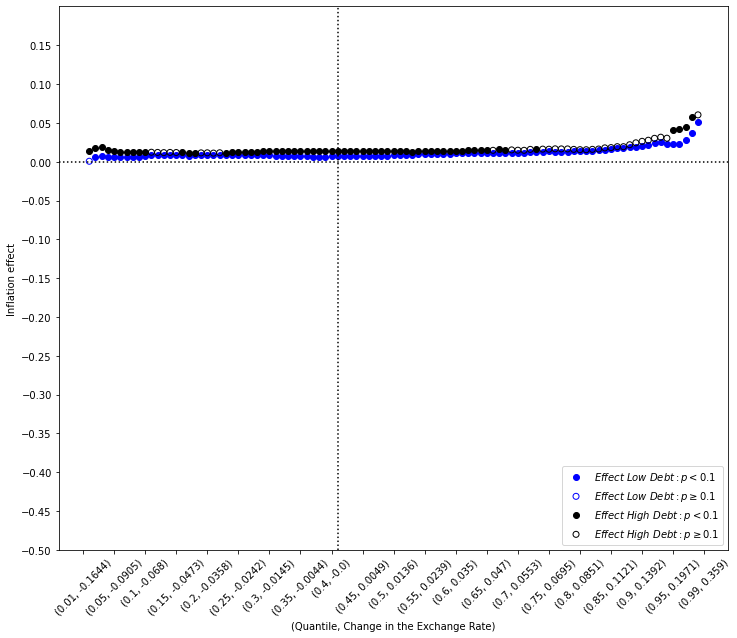

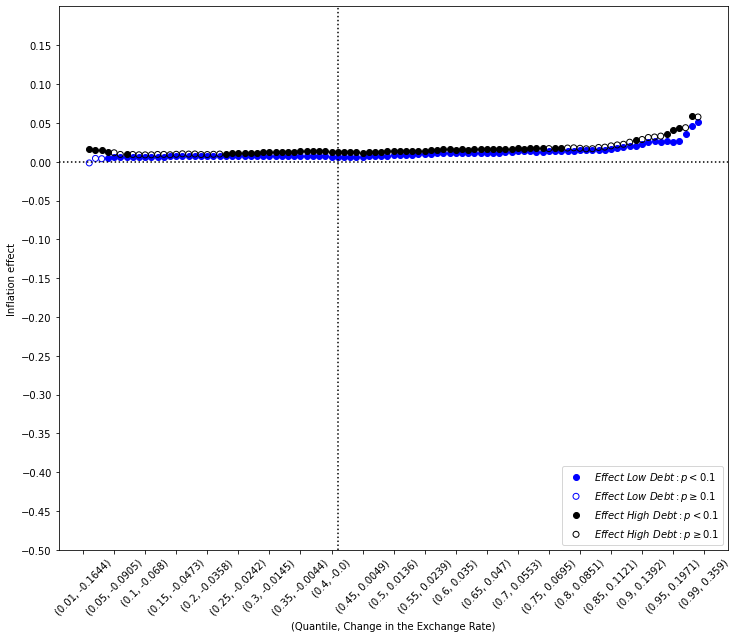

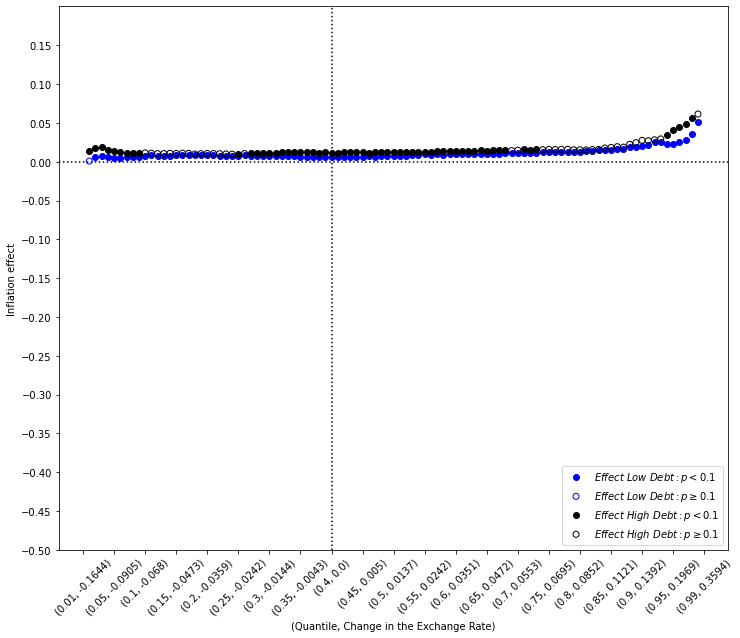

In [219]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Change in the Exchange Rate)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 0.2, -0.5
    # ymax, ymin = 0.007, -0.002
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: crecimiento

### Paramétros

In [220]:
DEPENDIENTE   =  "GDPG"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [221]:
dftc = dfr.copy()

### Estimación (tablas)

In [222]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'GDPG  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  0%|          | 0/99 [00:00<?, ?it/s]


KeyError: 'GDPG'

### Gráficas

In [124]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

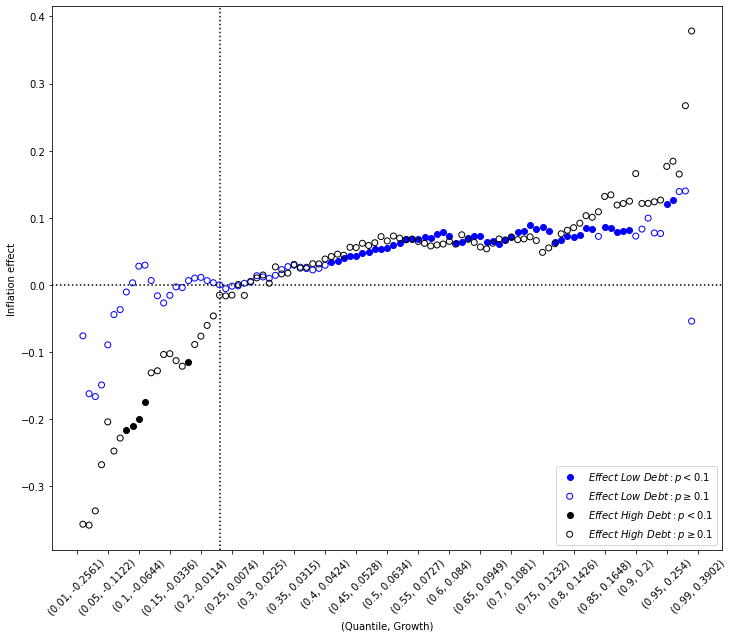

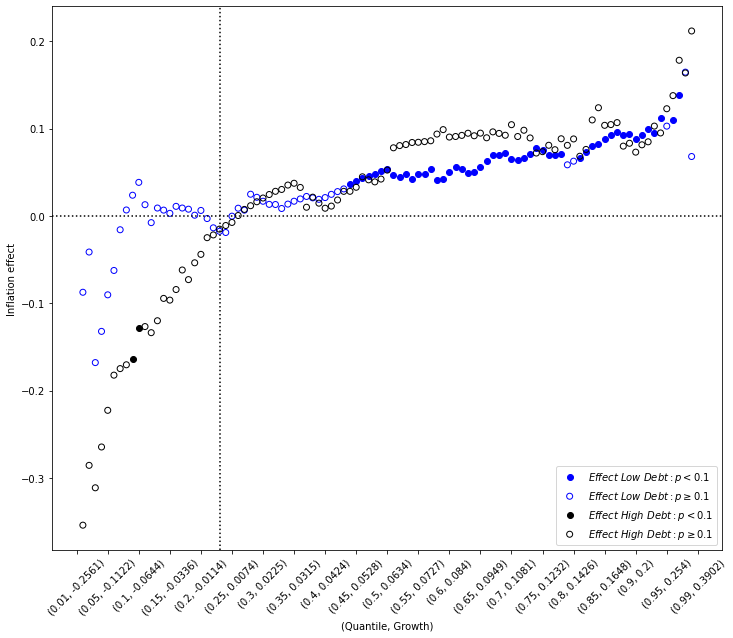

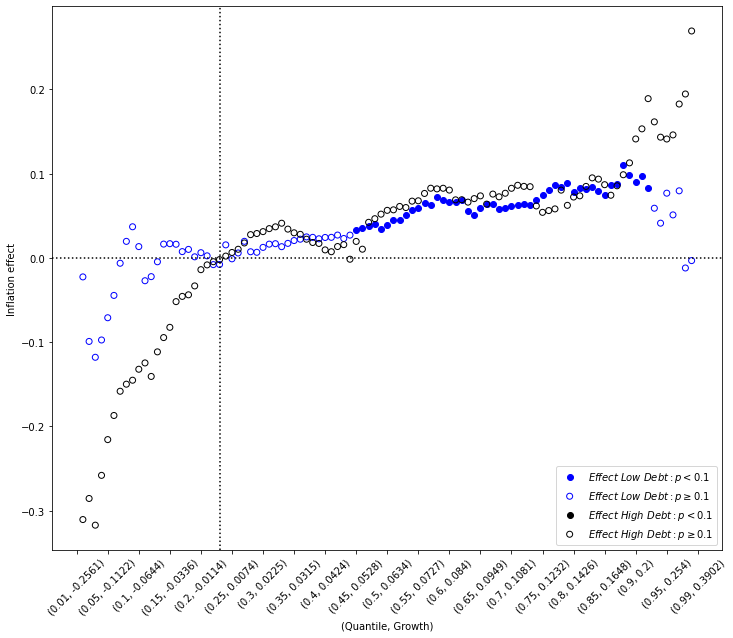

In [125]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Growth)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: deuda pública sector no financiero

### Paramétros

In [263]:
DEPENDIENTE   =  "PNFS_NFS"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [264]:
dftc = dfr.copy()

### Estimación (tablas)

In [265]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  9%|▉         | 9/99 [00:00<00:08, 10.15it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 14%|█▍        | 14/99 [00:01<00:13,  6.47it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 43%|████▎     | 43/99 [00:04<00:05, 10.79it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 56%|█████▌    | 55/99 [00:06<00:04, 10.93it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of

### Gráficas

In [266]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

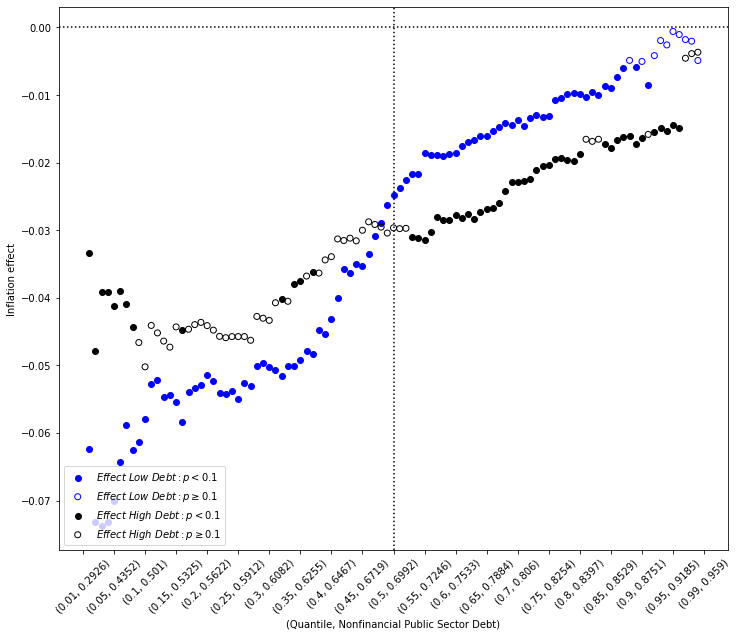

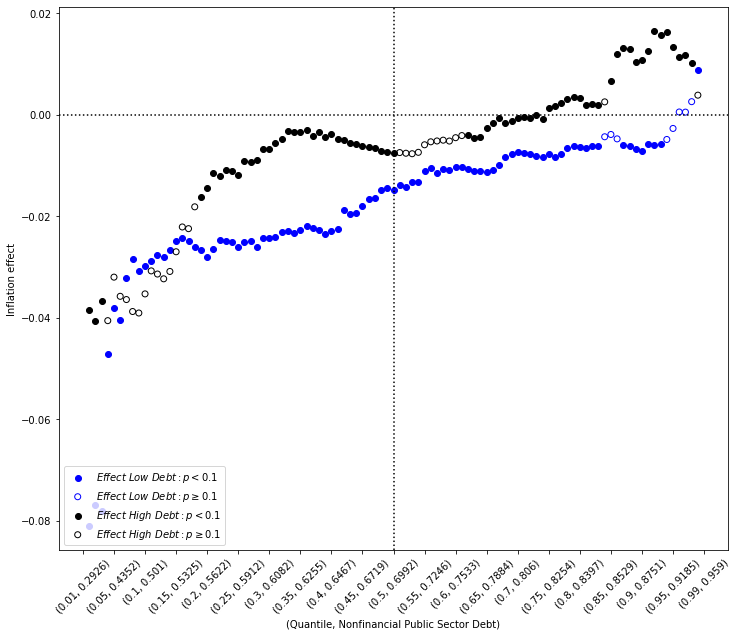

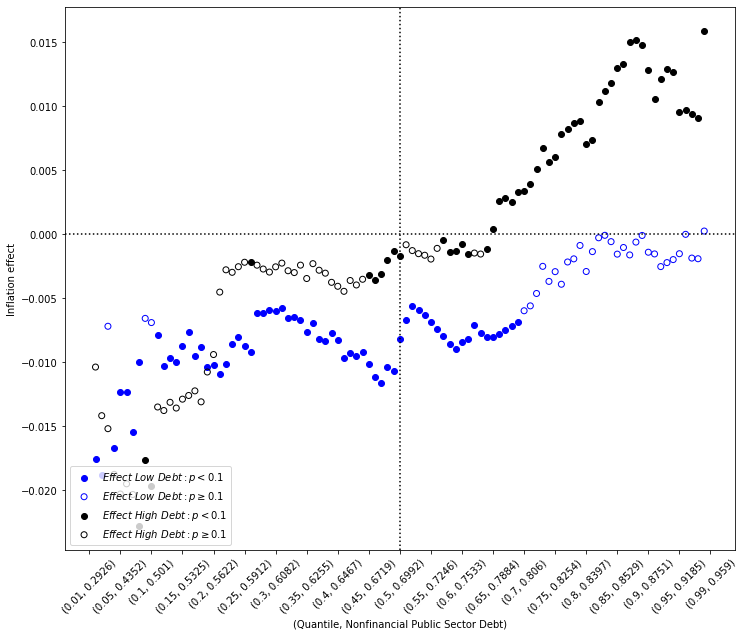

In [267]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Nonfinancial Public Sector Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower left')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: proporciónde bancos en manos de extranjeros

### Paramétros

In [268]:
DEPENDIENTE   =  "FOR1_DB"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [269]:
dftc = dfr.copy()

### Estimación (tablas)

In [270]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


100%|██████████| 99/99 [00:07<00:00, 13.96it/s]
<ipython-input-270-22c28950d1d0>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)
 17%|█▋        | 17/99 [00:01<00:09,  8.47it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 23%|██▎       | 23/99 [00:02<00:10,  7.17it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 57%|█████▋    | 56/99 [00:07<00:07,  5.52it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum num

### Gráficas

In [271]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

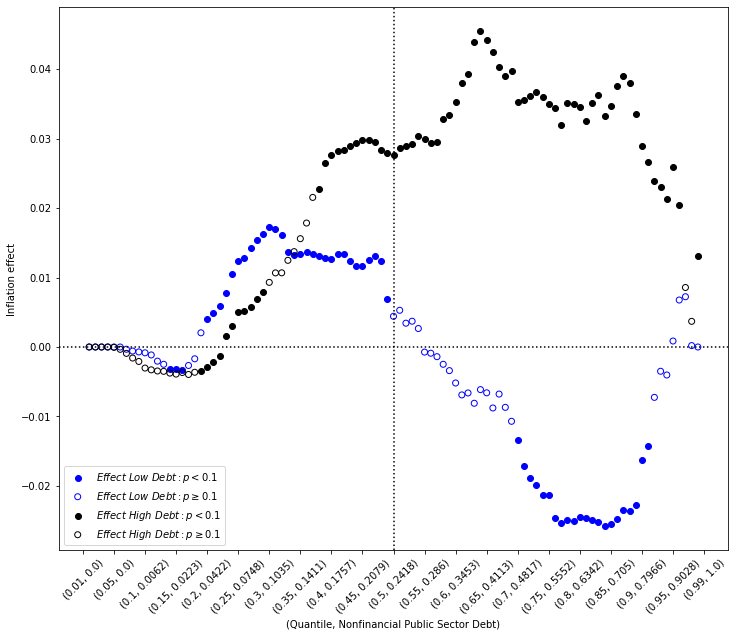

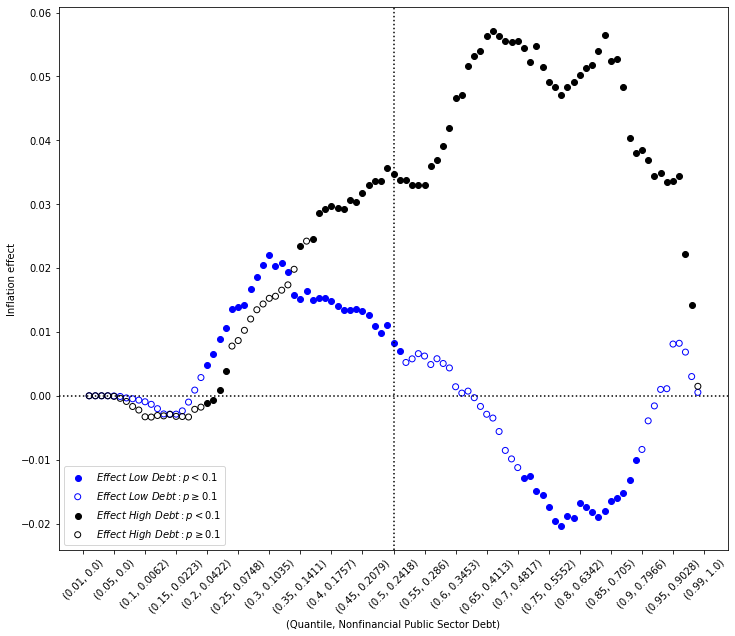

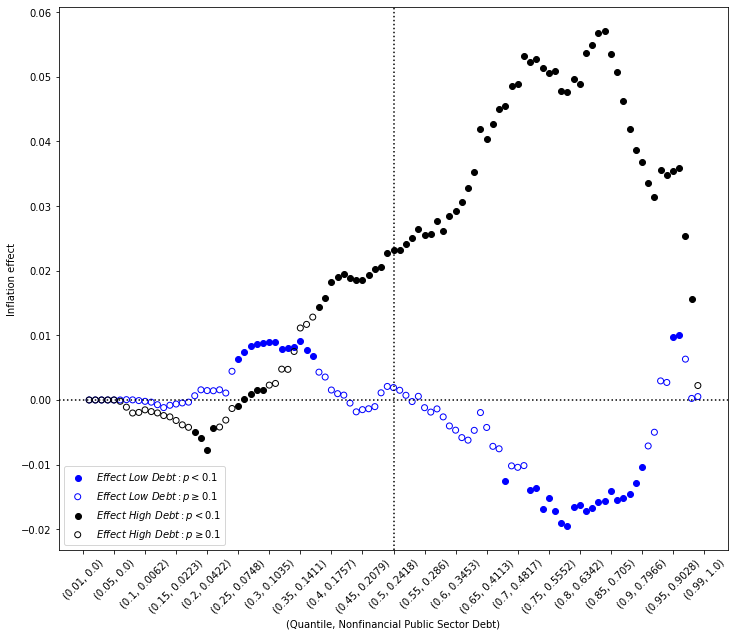

In [272]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.15 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.15 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Nonfinancial Public Sector Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower left')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()